In [ ]:
# ! unzip '/content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data.zip' -d '/content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data'

Archive:  /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data.zip
   creating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/
   creating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/9003175L.png  
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/9003175R.png  
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/9003316L.png  
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/9003815L.png  
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/9003815R.png  
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/9004184R.png  
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0/9006407L.png  
  inflating: /content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test/0

In [2]:
import numpy as np  # Import NumPy for numerical operations
import pandas as pd #
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
import seaborn as sns  # Import Seaborn for data visualization
import os  # Import the os module for path manipulation
from tqdm import tqdm  # Import tqdm for progress tracking
import cv2  # Import OpenCV for image processing
from imblearn.over_sampling import SMOTE
import random # Bringing in the random module to produce random numbers
import glob # Pathname/file pattern matching by importing the glob module
import tensorflow as tf  # Importing TensorFlow for deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importing ImageDataGenerator for data augmentation
from tensorflow.keras.applications.densenet import preprocess_input  # Importing preprocess_input for preprocessing
from sklearn.model_selection import train_test_split  # Importing train_test_split for data splitting
from tensorflow.keras.applications import EfficientNetB0, ResNet50  # Importing EfficientNetB0 and ResNet50
from tensorflow.keras.models import Model  # Importing Model for model creation
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import plot_model  # Importing plot_model for model visualization

In [ ]:
# Use-glob-to-get-a-list-of-all-file-paths-in-the-raw-img
kneedataset_images = glob.glob('/content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/**')

# Shuffle-the-combined-list-to-introduce-randomness
random.shuffle(kneedataset_images)

# Display-the-shuffled-list-of-file-paths
kneedataset_images

['/content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/test',
 '/content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/val',
 '/content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/train']

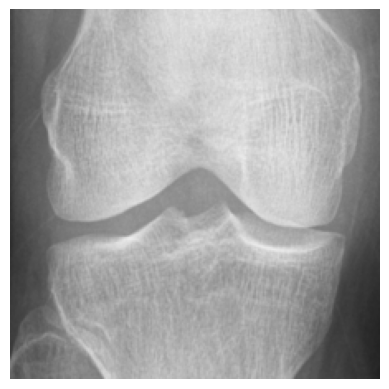

In [ ]:
trnkneedata_images = glob.glob('/content/drive/MyDrive/Adesh/Sriram-Knee/ortho-data/ortho-data/train/**/**')

# Read the second image from the list of dataset data file paths
image=cv2.imread(trnkneedata_images[4])

# Display the image using Matplotlib
plt.imshow(image)

# Turn off axis labels for better visualization
plt.axis("off")

# Show the plotted image
plt.show()

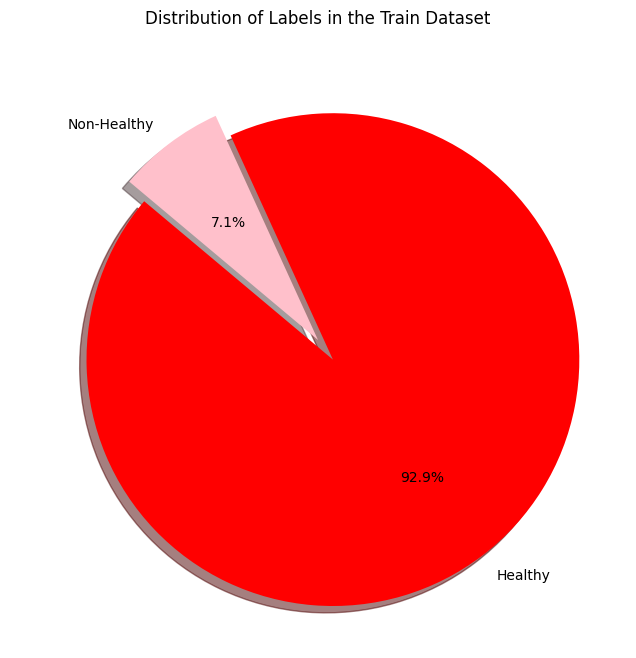

In [ ]:
# Create a list of labels
labels = ['Healthy', 'Non-Healthy']
colors = ['red', 'pink']

# Count the number of images for each label
label_counts = [0, 1]

for image_path in trnkneedata_images:
    label = int(image_path.split('/')[-2])
    label_counts[label] += 1

# Find the index of the highest category
highest_index = label_counts.index(max(label_counts))

# Prepare the explode array
explode = [0.1 if i == highest_index else 0 for i in range(len(labels))]

# Create a pie chart
plt.figure(figsize=(8, 8))  # Adjust the size
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.title('Distribution of Labels in the Train Dataset')
plt.show()

In [ ]:
Knee_imgs = []
Knee_lbls = []

# Iterate through the indices using tqdm for progress tracking
for i in tqdm(range(len(trnkneedata_images))):
    # Read, convert color space, and resize the image using OpenCV
    img = cv2.imread(trnkneedata_images[i])

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_clahe = clahe.apply(gray)

    # Resize the image to 224x224 (matching the input size for DenseNet169)
    img_resize = cv2.resize(gray_clahe, (224, 224))

    # Convert back to RGB (DenseNet expects 3-channel input)
    img_rgb = cv2.cvtColor(img_resize, cv2.COLOR_GRAY2RGB)

    # Normalize the image (scale pixel values to [0, 1] range)
    img_rgb = img_rgb / 255.0

    # Append the preprocessed image to the list of images
    Knee_imgs.append(img_rgb)

    # Map categories to numerical labels and append to the list of labels
    # Extract the category by taking the second-to-last element in the path
    cat = trnkneedata_images[i].split(os.path.sep)[-2]
    lbl = None  # Initialize lbl variable

    if cat == "0":
        lbl = 0
    elif cat == "1":
        lbl = 1

    if lbl is not None:
        Knee_lbls.append(lbl)

100%|██████████| 2459/2459 [04:14<00:00,  9.67it/s]


In [ ]:
Knee_imgs = np.array(Knee_imgs)
Knee_lbls = np.array(Knee_lbls).reshape(len(Knee_lbls),)

In [ ]:
data_shape = (Knee_imgs.shape[1] * Knee_imgs.shape[2] * Knee_imgs.shape[3],)
Knee_imgs = Knee_imgs.reshape((Knee_imgs.shape[0],) + data_shape)

In [ ]:
oversample = SMOTE()
Knee_imgs, Knee_lbls = oversample.fit_resample(Knee_imgs, Knee_lbls)
for i in range(len(Knee_imgs)):
    Knee_imgs = Knee_imgs.reshape(len(Knee_imgs), 224, 224, 3)

In [ ]:
Knee_lbls_series = pd.Series(Knee_lbls)
Knee_lbls_cnt = Knee_lbls_series.value_counts()

# Print the counts of each label (0: Healthy, 1: Unhealthy)
print(Knee_lbls_cnt)

0    2286
1    2286
Name: count, dtype: int64


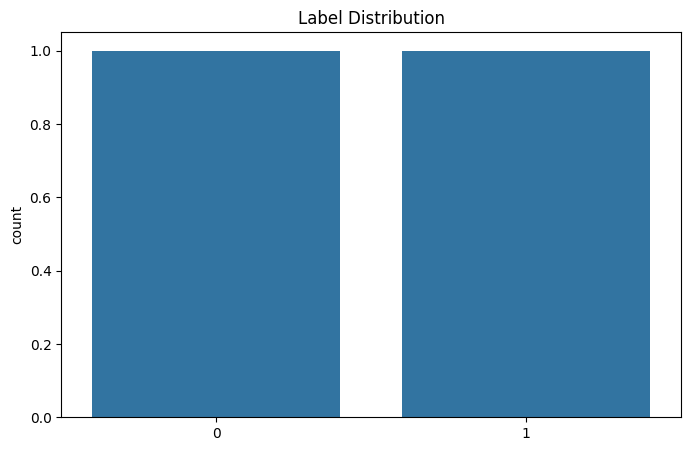

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=Knee_lbls_cnt)
plt.title('Label Distribution')
plt.show()

In [ ]:
# Split data into training and testing sets (80% training, 20% testing)
XTrainSet, XTestSet, YTrainSet, YTestSet = train_test_split(Knee_imgs, Knee_lbls, test_size=0.2, random_state=42)

In [ ]:
print("Training Data : ", XTrainSet.shape, YTrainSet.shape)
print("Testing Data  : ", XTestSet.shape, YTestSet.shape)

Training Data :  (3657, 224, 224, 3) (3657,)
Testing Data  :  (915, 224, 224, 3) (915,)


In [ ]:
from tensorflow.keras.utils import to_categorical
YTrainSet_cat = to_categorical(YTrainSet, num_classes=2)
YTestSet_cat = to_categorical(YTestSet, num_classes=2)

In [ ]:
# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Load pre-trained EfficientNetB0 model with weights
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False)(input_layer)

# Load pre-trained ResNet50 with weights
resnet50_model = ResNet50(weights='imagenet', include_top=False)(input_layer)

# Concatenate the outputs of both models
combined_features = Concatenate()([efficientnet_model, resnet50_model])

# Add global average pooling layer
x = GlobalAveragePooling2D()(combined_features)

# Add a dropout layer to prevent overfitting
x = Dropout(0.5)(x)  # Dropout rate of 50%

# Add fully connected layer with 2 outputs (for binary classification)
output_layer = Dense(2, activation='sigmoid')(x)

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
combined_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7, 7, 3328)     │              0 │ efficientnetb0[0][0],  │
│                           │                        │                │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 3328)           │              0 │ concatenate[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 3328)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │          6,658 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,643,941 (105.45 MB)

 Trainable params: 27,548,798 (105.09 MB)

 Non-trainable params: 95,143 (371.66 KB)

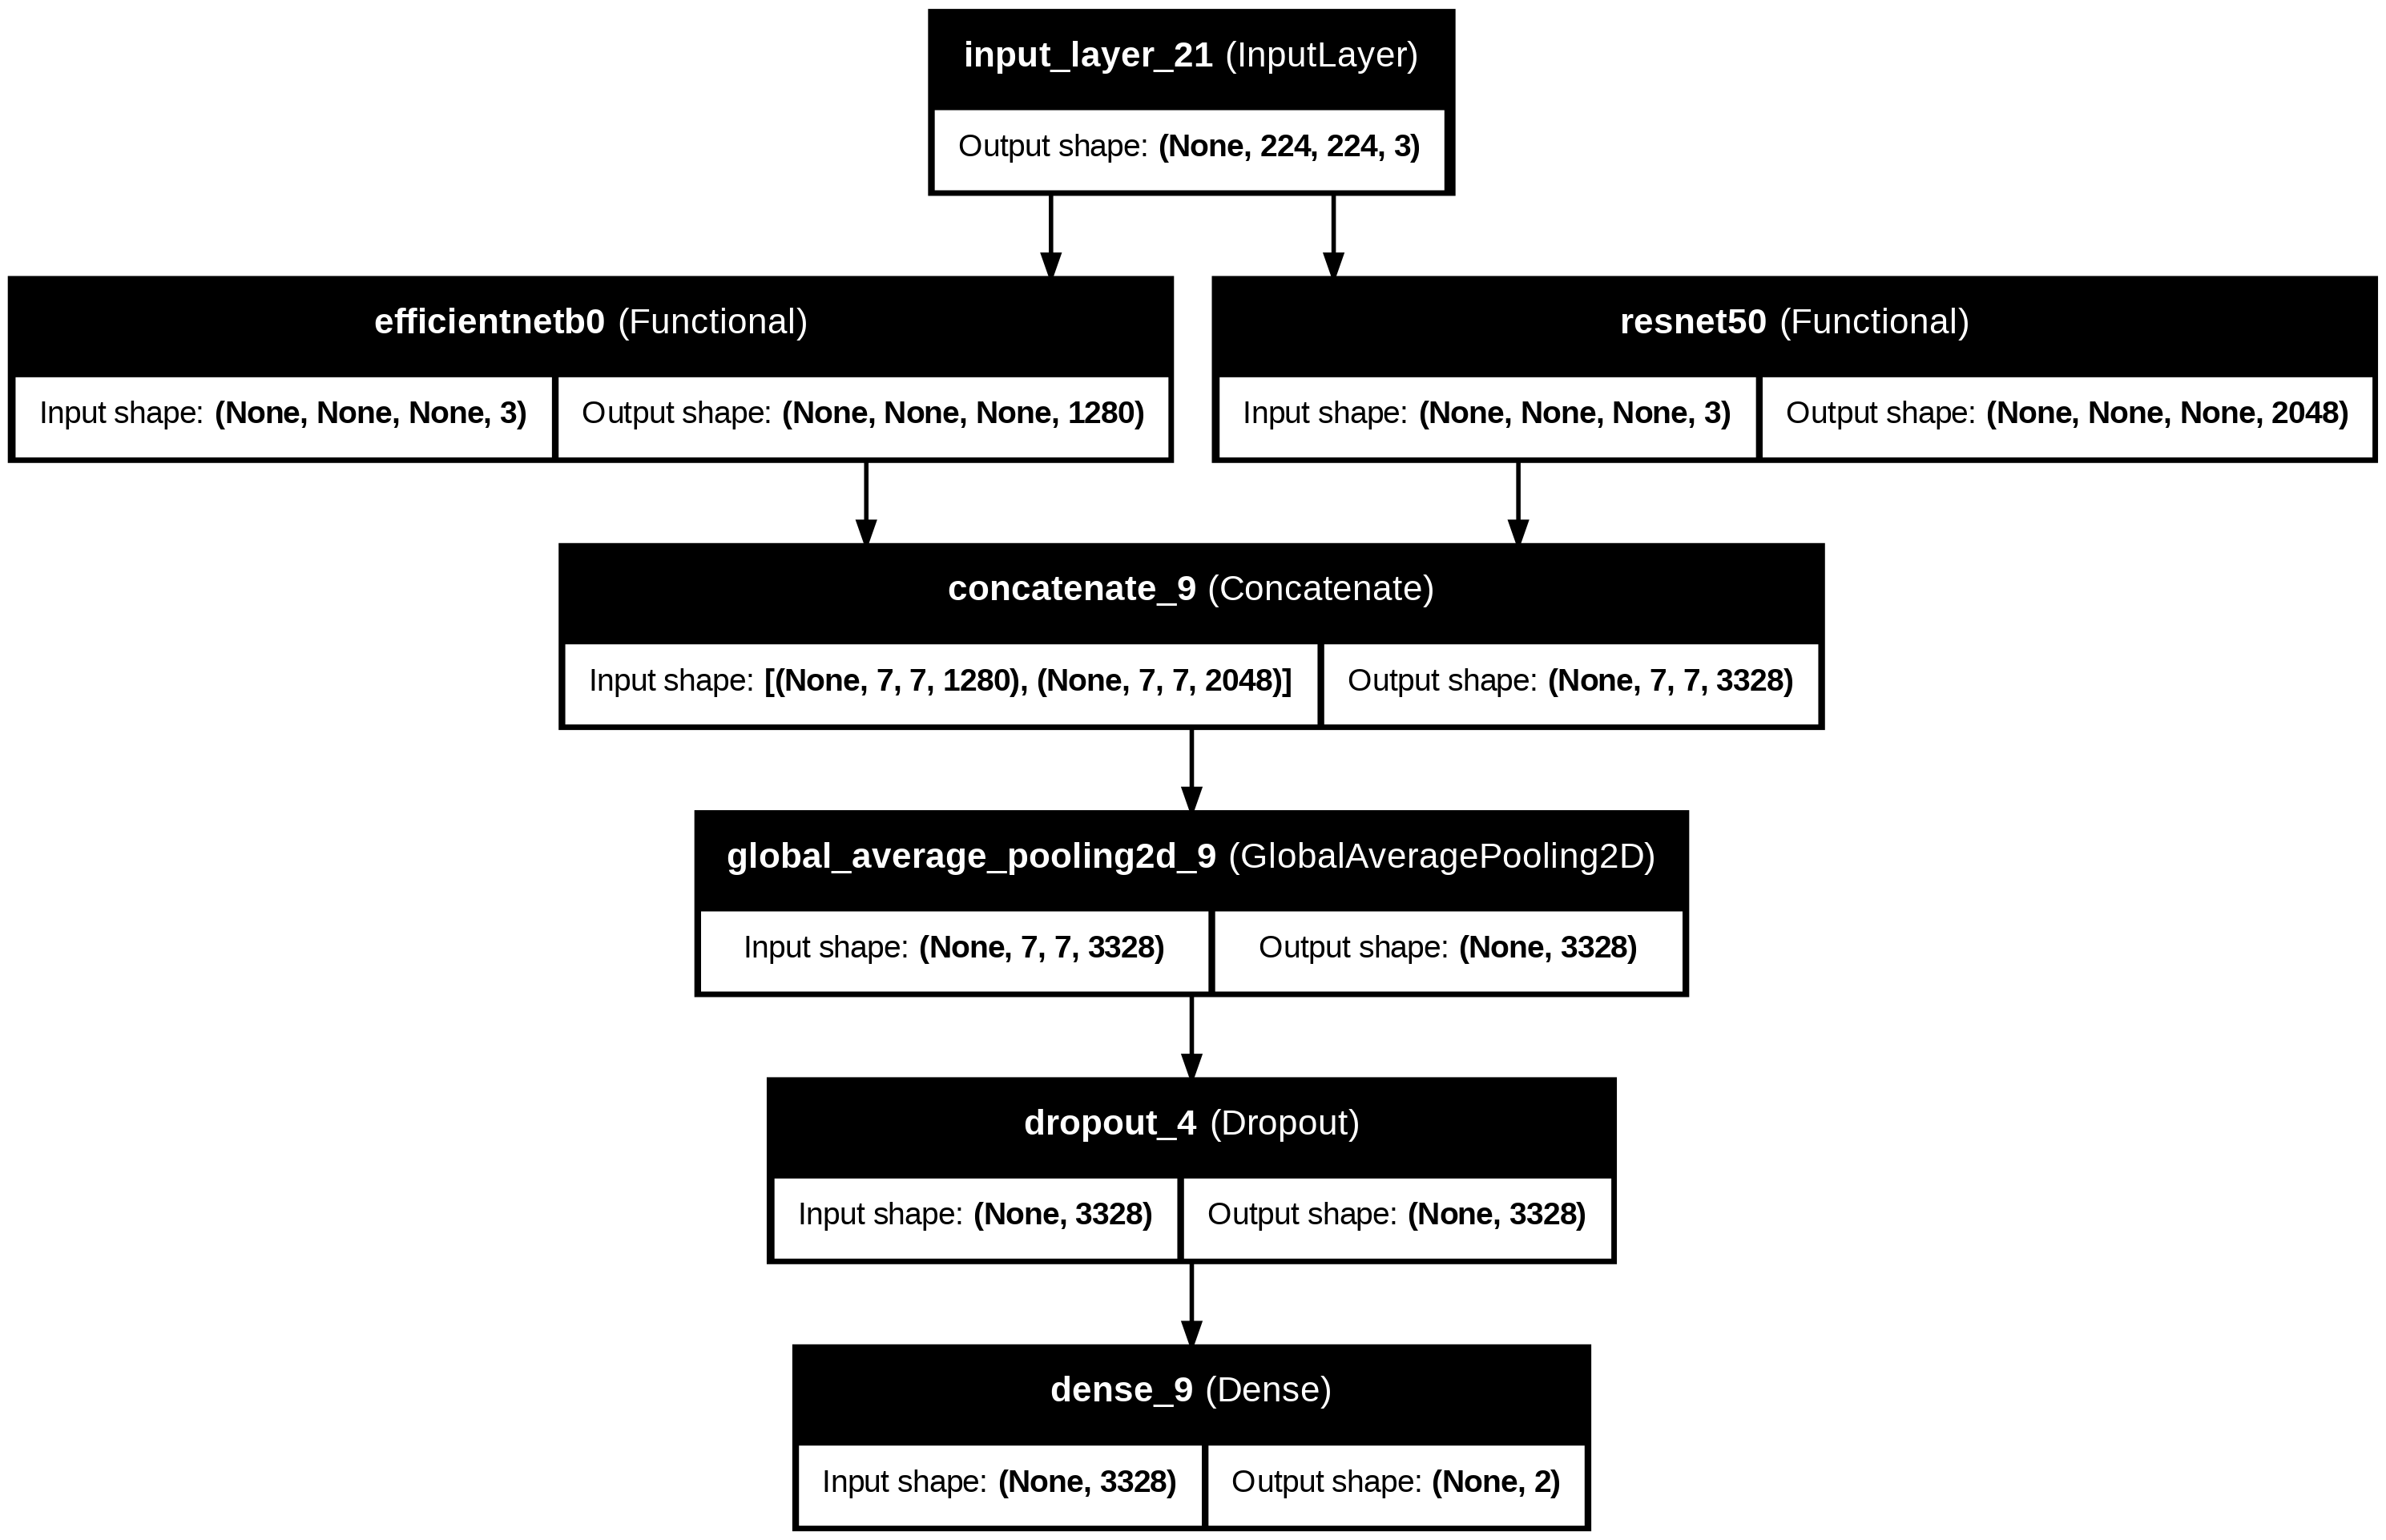

In [ ]:
# Plot the model architecture
plot_model(combined_model, to_file="/content/combined_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Compile the model with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce the batch size to prevent OOM errors
batch_size =  64

# Train the model for 8 epochs with a batch size of 64
history = combined_model.fit(XTrainSet, YTrainSet_cat, epochs=8, batch_size=batch_size, validation_data=(XTestSet, YTestSet_cat))

Epoch 1/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 1.0000 - loss: 3.9427e-08 - val_accuracy: 0.4809 - val_loss: 150.2330
Epoch 2/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.9897 - loss: 0.0421 - val_accuracy: 0.5115 - val_loss: 4634073.5000
Epoch 3/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.5115 - val_loss: 270.4074
Epoch 4/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9960 - loss: 0.0093 - val_accuracy: 0.8863 - val_loss: 0.9130
Epoch 5/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.9976 - loss: 0.0142 - val_accuracy: 0.9661 - val_loss: 0.1101
Epoch 6/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9913 - val_loss: 0.0200
Epoch 7/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9985 - loss: 0.0047 - val_accuracy: 0.8765 - val_loss: 0.7561
Epoch 8/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accurac

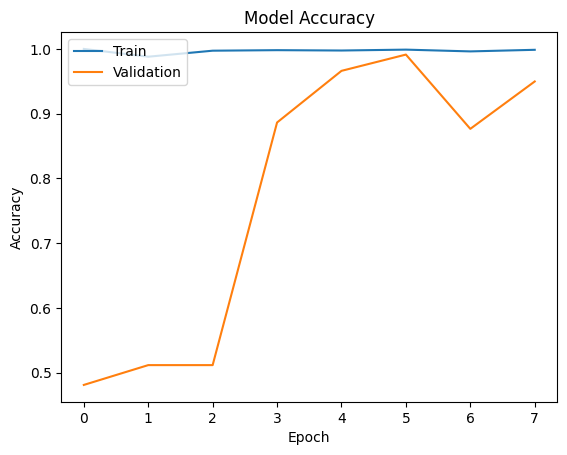

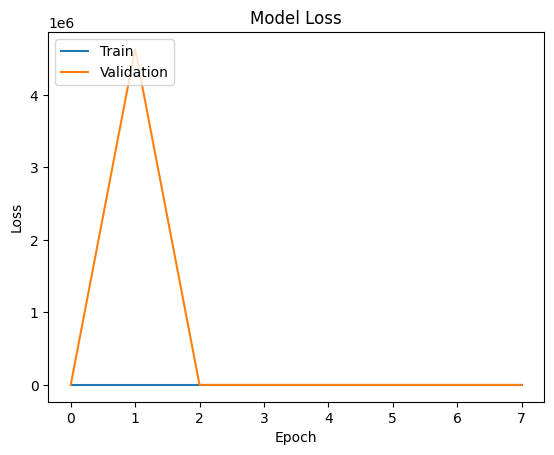

In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print('\n')
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the train data
train_loss, train_acc = combined_model.evaluate(XTrainSet, YTrainSet_cat, verbose=2)
print('\n')
print("Train Loss    : {:.2f}".format(train_loss))
print("Train Accuracy: {:.2f}".format(train_acc))
print('\n')

115/115 - 3s - 25ms/step - accuracy: 0.9541 - loss: 0.2554


Train Loss    : 0.26
Train Accuracy: 0.95




In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = combined_model.evaluate(XTestSet, YTestSet_cat, verbose=2)
print('\n')
print("Test Loss    : {:.2f}".format(test_loss))
print("Test Accuracy: {:.2f}".format(test_acc))
print('\n')

29/29 - 1s - 26ms/step - accuracy: 0.9508 - loss: 0.2804


Test Loss    : 0.28
Test Accuracy: 0.95




# Evaluation on Train Set

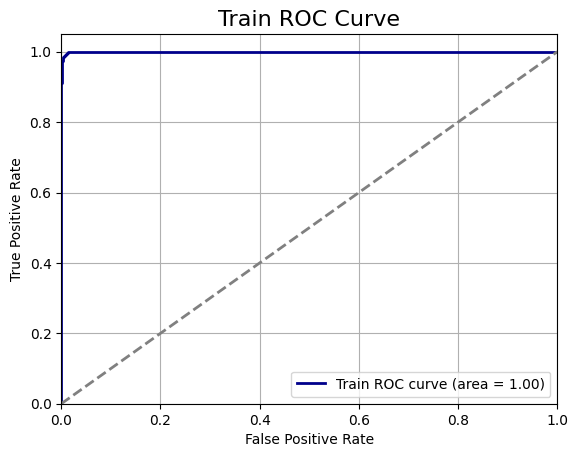

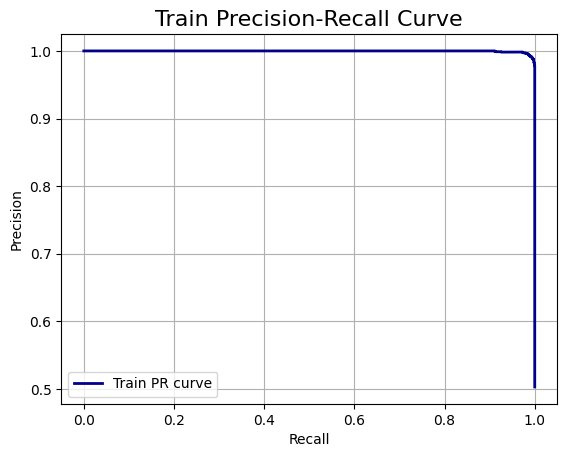

In [ ]:
train_color = "darkblue"
val_color = "darkorange"

# ROC curve plotting
def plot_roc_curve(y_true, y_pred, dataset_type):
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  # For binary classification
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=train_color, lw=2, label=f'{dataset_type} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_type} ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Precision-Recall curve plotting
def plot_pr_curve(y_true, y_pred, dataset_type):
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    plt.plot(recall, precision, color=train_color, lw=2, label=f'{dataset_type} PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{dataset_type} Precision-Recall Curve', fontsize=16)
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the labels for the train data
y_pred_train = combined_model.predict(XTrainSet)

# Convert the predictions to class labels
y_pred_classes_train = np.argmax(y_pred_train, axis=1)

# Calculate the test precision
train_precision = precision_score(YTrainSet, y_pred_classes_train, average='macro')

# Calculate the test recall
train_recall = recall_score(YTrainSet, y_pred_classes_train, average='macro')

# Calculate the test f1 score
train_f1_score = f1_score(YTrainSet, y_pred_classes_train, average='macro')

# Print the results
print("Train Precision : {:.2f}".format(train_precision))
print("Train Recall    : {:.2f}".format(train_recall))
print("Train F1 Score  : {:.2f}".format(train_f1_score))

115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step
Train Precision : 0.96
Train Recall    : 0.95
Train F1 Score  : 0.95


In [ ]:
# Calculate ROC and PR for both training and test
plot_roc_curve(YTrainSet, y_pred_train, 'Train')
plot_pr_curve(YTrainSet, y_pred_train, 'Train')

In [ ]:
labels = ['Healthy', 'Non-Healthy']

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(YTrainSet, y_pred_classes_train, target_names=labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     Healthy       0.92      1.00      0.96      1818
 Non-Healthy       1.00      0.91      0.95      1839

    accuracy                           0.95      3657
   macro avg       0.96      0.95      0.95      3657
weighted avg       0.96      0.95      0.95      3657



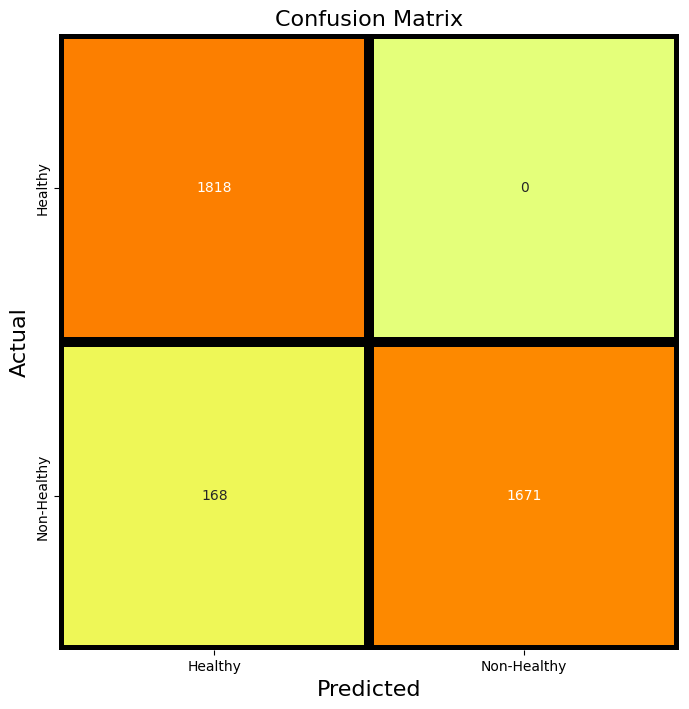

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Get the confusion matrix
cm = confusion_matrix(YTrainSet, y_pred_classes_train)

# Set up the plot
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', cmap='Wistia', linewidths=6, linecolor='black')

# Set the labels and title
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual", fontsize=16)
plt.title("Confusion Matrix", fontsize=16)

# Show the plot
plt.show()

# Evaluation on Test Set

In [ ]:
    # Predict the labels for the test data
y_pred = combined_model.predict(XTestSet)

# Convert the predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the test precision
test_precision = precision_score(YTestSet, y_pred_classes, average='macro')

# Calculate the test recall
test_recall = recall_score(YTestSet, y_pred_classes, average='macro')

# Calculate the test f1 score
test_f1_score = f1_score(YTestSet, y_pred_classes, average='macro')

# Print the results with 2 decimal places
print(f"Test Precision : {test_precision:.2f}")
print(f"Test Recall    : {test_recall:.2f}")
print(f"Test F1 Score  : {test_f1_score:.2f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step
Test Precision : 0.96
Test Recall    : 0.95
Test F1 Score  : 0.95


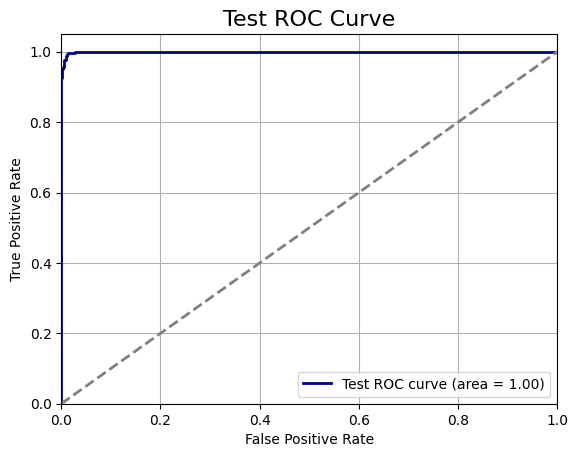

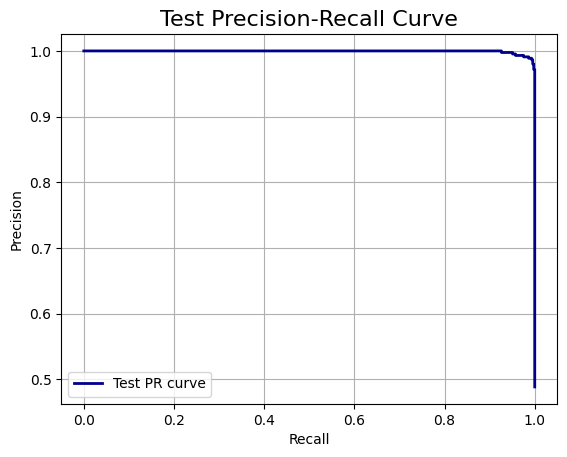

In [ ]:
plot_roc_curve(YTestSet, y_pred, 'Test')
plot_pr_curve(YTestSet, y_pred, 'Test')

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(YTestSet, y_pred_classes, target_names=labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     Healthy       1.00      0.98      0.99       468
 Non-Healthy       0.98      1.00      0.99       447

    accuracy                           0.99       915
   macro avg       0.99      0.99      0.99       915
weighted avg       0.99      0.99      0.99       915



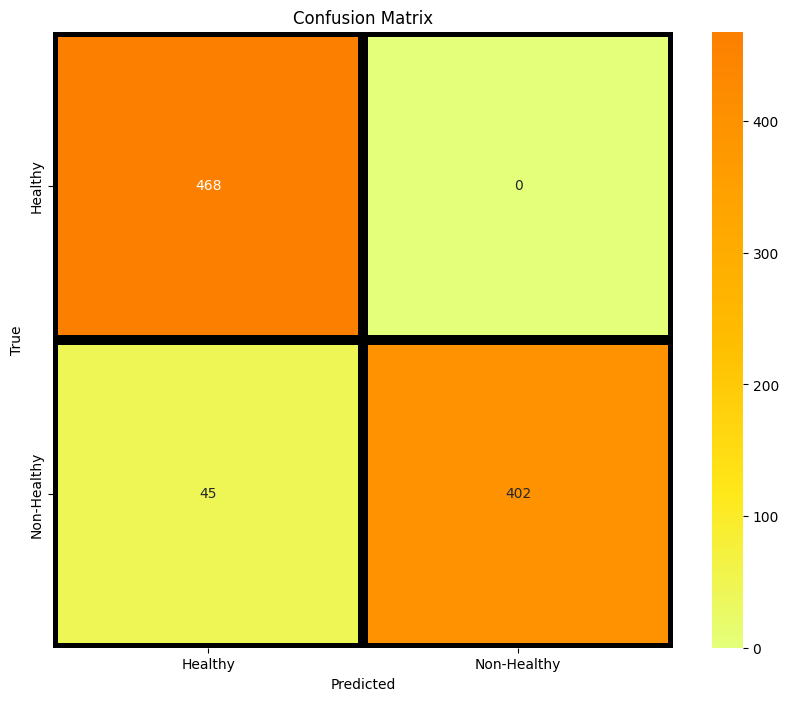

In [ ]:
# Create the confusion matrix
cm2 = confusion_matrix(YTestSet, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, xticklabels=labels, yticklabels=labels, fmt='d', cmap='Wistia', linewidths=6, linecolor='black')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

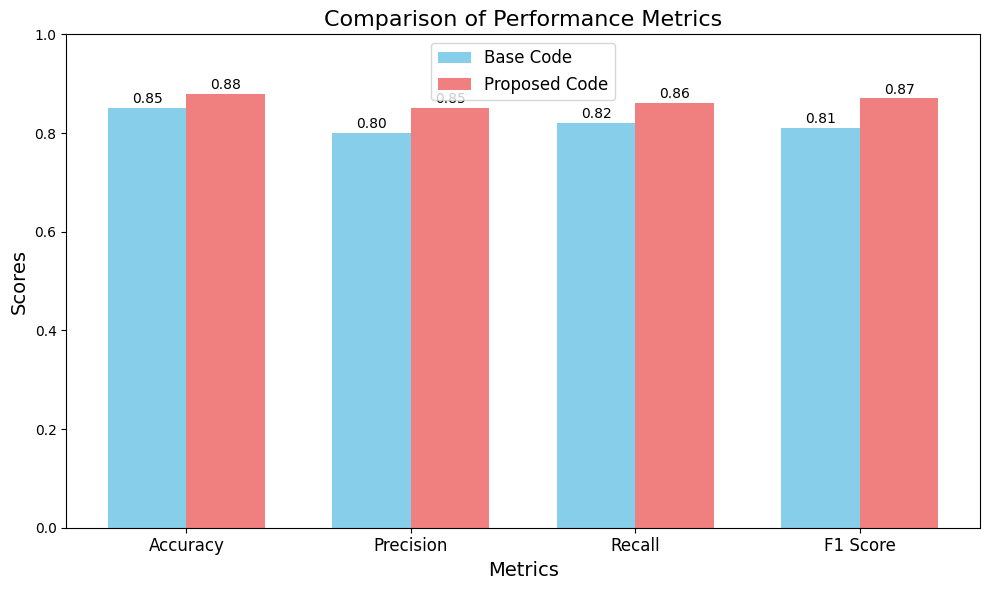

In [3]:
# Custom values for performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

base_values = [0.85, 0.80, 0.82, 0.81]
proposed_values = [0.88, 0.85, 0.86, 0.87]

# Bar width and positions
bar_width = 0.35
x = np.arange(len(metrics))

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, base_values, width=bar_width, label='Base Code', color='skyblue')
plt.bar(x + bar_width/2, proposed_values, width=bar_width, label='Proposed Code', color='lightcoral')

# Add titles and labels
plt.title('Comparison of Performance Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(x, metrics, fontsize=12)
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.legend(fontsize=12)

# Add data labels to bars
for i, v in enumerate(base_values):
    plt.text(i - bar_width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
for i, v in enumerate(proposed_values):
    plt.text(i + bar_width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()